In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Modelo de RML en un Activo Financiero

En este tutorial aplicaremos la función de lm() para ejemplificar su uso en la modelación de una serie de precios. Este tutorial es complementario al tutorial "Modelos de Regresión Lineal Múltiple", donde empleamos diversas funciones para generar modelos de regresión que aplicamos a una serie mensual que presentaba los componentes de tendencia y estacionariedad mensual. En esta ocasión, aplicaremos la función lm() a una serie de frecuencia diaria, donde las funciones tslm() y TimeModel requerirían un proceso adicional para la identificación de tales frecuencias. En estas situaciones, la función lm() es comúnmente empleada.

**Contenido**
1. [Importación de librerías requeridas](#2)
1. [Importación de datos financieros](#3)
1. [Indexado de fecha y visualización](#4)
1. [Identificación de features](#5)
1. [Cambio de nombres de columnas](#6)
1. [Generación de features](#7)
1. [Partición de datos en entrenamiento y prueba](#8)
1. [Especificación del modelo lineal](#9)
1. [Proceso de pronóstico en conjunto de prueba](#10)
1. [Obtención de métricas de error](#11)
1. [Generación del pronóstico hacia adelante](#12)


<a id="2"></a> <br>
### Importación de librerías requeridas

Importa las siguientes librerías para desarrollar este tutorial:

In [ ]:
library(TSstudio)
library(dplyr)
library(lubridate)

library(plotly)
library(forecast)
#install.packages("Metrics")
library(Metrics)
library(astsa)
library(quantmod)
library(xts)
library(dygraphs)


In [ ]:
#podemos deshabilitar los avisis de warnings para comodidad de lectura.
options(warn = - 1)

<a id="3"></a> <br>
### Importación de datos financieros

In [ ]:
###Función de obtención de datos financieros de yahoo finance. Establecemos las fechas de estudio.
start<-format(as.Date("2014-01-01"),"%Y-%m-%d")
end<-format(as.Date("2021-06-30"),"%Y-%m-%d")

precios <-function(simbolo)  #para evitar posibles confusiones del código, omitimos las tildes.
{
  ##Obtener precios stocks de Yahoo Finance
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  ## Elimar faltantes:
  datos<-na.omit(datos)
  ##mantener columnas con precios cierre y volumenes: columnas 4 y 5:
  datos <- datos[,4]
  ##Para hacer los datos accesibles en el global environment:
  assign(simbolo, datos, envir = .GlobalEnv)
}


In [ ]:
# Definimos qué activo deseamos estudiar. Se reporta mediante el "ticker" que posee en yahoo finance. Pueden ser varios a estudiar.
precios("AMZN")

In [ ]:
##Juntamos los datos y renombramos:
Pr<-merge.xts(AMZN)
head(Pr)
colnames(Pr) <- c("Amzn")
head(Pr)
##Serie tiempo, gráfica interactiva
Precios<- dygraph(Pr[,c(1)], main="Precios ") %>%
  dyAxis("y", label = "Precios") %>%
  dyRangeSelector(dateWindow = c("2014-01-01", "2021-07-30"))%>%
  dyOptions(colors = RColorBrewer::brewer.pal(4,"Set1"))
Precios

In [ ]:
# Podemos ver los 5 últimos datos redondeando hasta 3 decimales:
round(head(Pr, n = 5), 3)

<a id="4"></a> <br>
### Indexado de fecha y visualización

Para poder generar una visualización con ggplot y demás operaciones como la generación de features, es común cambiar el tipo de formato de la fecha, de un xts, a uno tipo zoo y finalmente a data.frame.

In [ ]:
##Comenzamos dando formato a la fecha y luego generamos el cambio del formato respectivo. Finalmente, renombramos las columnas.
xpr <- as.xts(AMZN, dateFormat = "Date")
amzn_index <- fortify.zoo(xpr)
colnames(amzn_index)<-c("Index", "AMZN")
head(amzn_index)

<a id="5"></a> <br>
### Identificación de features
Podemos aplicar la función de descomposición de la serie para identificar la forma de los componentes si existe por ejemplo una estacionalidad o la forma de la tendencia. Aplicaremos:
* Descomposición
* Identificación de features mediante tsfeatures()
* Exploración de serie por rezagos 


In [ ]:
# la función mstl, para la descomposición de series de tiempo.
mstl(amzn_index$AMZN)%>% autoplot()

In [ ]:
#Igualmente, podemos emplear la función de tsfeatures() a la serie para tener idea de la estacionalidad, linealidad y complejidad para su pronosticabilidad, medida esta última pro el métrico de entropia.
library(tsfeatures)
tsfeatures(amzn_index$AMZN)

In [ ]:
#### Exploración Serie:
library(TSstudio)
ts_lags(AMZN, lags = c(1,2,3,4,5,9,10,60,120, 360))

In [ ]:
acf(diff(amzn_index$AMZN), lag.max =60)

Como podemos ver en la gráfica de la Función de Autocorrelación o ACF, existen rezagos que no muestran una multiplicidad que evidencie una estacionalidad. Podemos así, confirmar lo que la descomposición indica, que no hay una estacionalidad aparente en los datos.

<a id="6"></a> <br>
### Cambio nombres columnas

Para facilitar la escritura del código, hacemos un cambio simple en los nombres de las columnas.

In [ ]:
###llamaremos ahora "date" y "y" sin importar el nombre del activo que estudiemos.
dataf <- amzn_index
names(dataf) <- c("date", "y")
head(dataf)
str(dataf)


<a id="7"></a> <br>
### Generación de features

En esta parte, debemos generar las columnas de los features, que corresponden a los componentes que identificamos son relevantes para ser capturados en el modelo de regresión. Por ejemplo, los rezagos significativos que vimos en las secciones anteriores (exploración de la serie, por ejemplo), así como los componentes que forman la tendencia. En este sentido, comenzamos a generar un vector con una tendencia lineal, otra con una tendencia cuadrática y así sucesivamente acorde el grado de la forma de la tendencia; en este caso probaremos una cúbica. Este conjunto de features, forman la base de features de toda la serie para que posteriormente, podamos partirla en sección de entrenamiento o "x_train" y sección de prueba o "x_test".

In [ ]:
#Generamos los features hasta 5 días de retraso
lag_pra = lag(amzn_index$AMZN,n=1L) 
lag2_pra = lag(amzn_index$AMZN,n=2L) 
lag3_pra = lag(amzn_index$AMZN,n=3L) 
lag4_pra = lag(amzn_index$AMZN,n=4L) 
lag5_pra = lag(amzn_index$AMZN,n=5L)

In [ ]:
#Unimos los rezagos una una base con columnas y omitimos los faltantes que se generan por los rezagos.
amzn_all<-cbind(amzn_index, lag_pra, lag2_pra, lag3_pra, lag4_pra, lag5_pra) %>%na.omit()
head(amzn_all)

In [ ]:
#renombramos las columnas para facilidad posterior
colnames(amzn_all)<-c("date","Amzn","l1","l2","l3","l4","l5")
head(amzn_all)

In [ ]:
#Generamos las columnas de tendencia lineal, cuadrática y cúbica.
amzn_all$trend = 1:nrow(amzn_all)
amzn_all$trend2 =  amzn_all$trend^2
amzn_all$trend3 =  amzn_all$trend^3
str(amzn_all)
head(amzn_all)
tail(amzn_all)

In [ ]:
#Identificamos la longitud de la serie.
nrow(amzn_all)

<a id="8"></a> <br>
### Partición de datos en entrenamiento y prueba

In [ ]:
##h: horizonte pronóstico. Consideremos una ventana de prueba del 4%, que representan 75 días de validación. Usualmente este porcentaje
# va hasta el 20%. 
h <- round(nrow(amzn_all)*0.04, digits = 0 )
h
amzn_train <- amzn_all[1:(nrow(amzn_all) - h), ]
amzn_test<- amzn_all[(nrow(amzn_all) - h + 1):nrow(amzn_all), ]

In [ ]:
#Podemos ver qué tipo de objetos obtenemos en cada sección.
str(amzn_all)
str(amzn_train)
str(amzn_test)
head(amzn_train)

<a id="9"></a> <br>
## Especificación del modelo lineal

Ya listos los datos para el modelo, aplicamos la función lm(), indicando la respuesta y los regresores.

In [ ]:
####Modelo de referencia: Modelo Lineal
lr <- lm(Amzn ~ l1 + l2  + l3 + l4 + trend + trend2 + trend3, data = amzn_train)
summary(lr)

In [ ]:
#Podemos depurar el modelo, eliminando la tendencia cuadrática
lr2 <- lm(Amzn ~ l1 + l2  + l3 + l4 + trend +trend2, data = amzn_train)
summary(lr2)

<a id="10"></a> <br>
## Proceso de pronóstico en conjunto de prueba
Para el pronóstico y validación del modelo, empleamos el modelo lineal del paso anterior con los datos de la sección de prueba.

In [ ]:
head(amzn_test)

In [ ]:
amzn_test$yhat <- predict(lr2, newdata = amzn_test, ts=TRUE)
tail(amzn_test)
str(amzn_test)

In [ ]:
###
plot_ly(x = amzn_all$date, y = amzn_all$Amzn,
        type = "scatter",
        mode = "line", 
        name = "Actual") %>% 
  add_lines(x = amzn_test$date, y = amzn_test$yhat, name = "LM") %>%
  layout(title = "Total Vol - Final Forecast", yaxis = list(title = "Price @ Los Andes", range = c(0, 200)),
         xaxis = list(title = "Date", range = c(start, end)))

In [ ]:
#Otra visualización, con ggplot:
amzn_all %>%
  ggplot(aes(date, Amzn)) +
  geom_line() +
  geom_line(aes(date, yhat), data = amzn_test, color = "red")

<a id="11"></a> <br>
### Obtención de métricas de error

In [ ]:
#Descargamos las paqueterías requeridas. Una de las más usuales es la paquetería Metrics.
library(Metrics)
rmse_lr <- rmse(amzn_test$Amzn, amzn_test$yhat)
rmse_lr
mape_lr <- mape(amzn_test$Amzn, amzn_test$yhat)
mape_lr
mae_lr <- mae(amzn_test$Amzn, amzn_test$yhat)
mae_lr
#Podemos generar una tabla que resume los tipos de error: RMSE (Root square mean absolute error), RSQ (Root square error) y MAE (Mean absolute error).
yardstick::metrics(amzn_test, truth = Amzn, estimate = yhat)

Como podemos ver, el modelo lineal genera un buen ajuste a los datos, así como buenas métricas de pronóstico.
Comparado con los modelos de regresión adaptativa, teníamos:

* RMSE GAM:  2.40129434648197
* RMSE MARS: 2.31680326836852
* RMSE TPS:  2.9245972128849

* MAPE GAM:  0.0118425971784523
* MAPE MARS: 0.0118500799190091
* MAPE TPS:  0.0145750092510183

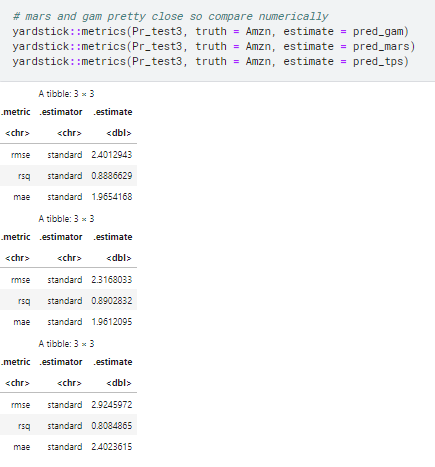

En este caso, la función paramétrica a través de lm() que empleamos en este tutorial genera mejores resultados de pronóstico medidos con los tipos de error rmse y mae en comparación con los modelos de regresión obtenidos con las funciones adaptativas de splines.

<a id="12"></a> <br>
## Generación del pronóstico hacia adelante

Aplicamos el modelo seleccionado a toda la serie, para poner generar el pronóstico hacia adelante. 

In [ ]:
mod_all <- lm(Amzn ~ l1 + l2  + l3 + l4 + trend +trend2, data = amzn_all)
summary(mod_all)

In [ ]:
# Aplicamos la función de predicción, a partir de los úlimos datos de la serie, lo cuál es muy entendible ya que nos importa más los eventos recientes para el pronóstico de los siguientes días.
lm_fwd_amzn<-predict.lm(mod_all, interval = "prediction")[1868:1881,]
lm_fwd_amzn

In [ ]:
#Generamos una secuencia de fechas para estos nuevos valores de predicción, que facilitará la visualización.
starter_df_amzn <- data.frame(dates=seq(from=(as.POSIXct(strftime("2021-06-30"))),
                               length.out = 14, 
                               by="1 day"),
                     data = lm_fwd_amzn)

In [ ]:
#Los pegamos a la serie anterior.
full_data_amzn <- data.frame(dates=seq(from=min(starter_df_amzn$dates),
to=max(starter_df_amzn$dates), by="1 day"),
data=rep(NA,NROW(seq(from=min(starter_df_amzn$dates),
to=max(starter_df_amzn$dates), by="1 day"))))

full_data_amzn[full_data_amzn$dates %in% starter_df_amzn$dates,] <- starter_df_amzn[starter_df_amzn$dates %in% full_data_amzn$dates,]
head(full_data_amzn)

In [ ]:
head(amzn_all)

In [ ]:
## Y podemos graficar, podemos retomar las fechas de análisis del modelo de referencia.
#start<-format(as.Date("2014-01-01"),"%Y-%m-%d")
#end<-format(as.Date("2021-06-30"),"%Y-%m-%d")
library(plotly)
start<-format(as.Date("2014-01-01"),"%Y-%m-%d")
end<-format(as.Date("2021-12-30"),"%Y-%m-%d")
plot_ly(x = amzn_all$date, y = amzn_all$Amzn,
        type = "scatter",
        mode = "line", 
        name = "Actual") %>% 
  add_lines(x = mod_all$date, y = mod_all$yhat, name = "LM") %>%
  add_lines(x = full_data_amzn$dates, y = full_data_amzn$data, name = "LM FWD AMZN") %>%
  layout(title = "LM Forecast", yaxis = list(title = "Amzn Close Price @ Los Andes", range = c(0, 300)),
         xaxis = list(title = "Date", range = c(start, end)))

En este tutorial, aprendiste a modelar una serie financiera con periodicidad diaria, donde aplicamos la función de lm() para generar el modelo de regresión y pronosticar 14 días hacia adelante el precio del activo. 
Continuemos así con nuestro ejercicio práctico, para el desarrollo de las habilidades de modelación.